In [ ]:
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from tensorflow.keras import models, layers, preprocessing 
from tensorflow.keras import backend as K

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 9.7 MB/s 
     |████████████████████████████████| 120 kB 58.3 MB/s 
     |████████████████████████████████| 6.6 MB 38.4 MB/s 


In [ ]:
import tensorflow as tf
import transformers #bert language model
%matplotlib inline

In [ ]:
!pip install numpy requests nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 30.3 MB/s 


In [ ]:
import nlpaug.augmenter.word as nlpaw
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Snowballing dataset

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/datasets/Snowball/Training.csv')
df_test = pd.read_csv('/content/drive/My Drive/datasets/Snowball/Testing.csv')

In [ ]:
df_train.head()

,Title,Abstract,Relevance
0,A Guide To The Project Management Body Of Know...,Its hard to imagine a time when A Guide to the...,0
1,Continuing Professional Development by Practit...,To prevent skilled professionals from being ph...,0
2,On a partnership between software industry and...,This paper discusses a role for industry in so...,0
3,Network Analysis of a Large Scale Open Source ...,One way to understand the structure of an open...,0
4,Design Science in Information Systems Research,Two paradigms characterize much of the researc...,0


In [ ]:
df_test.head()

,Title,Abstract,Relevance
0,Structuring automotive product lines and featu...,Automotive systems are highly complex and cust...,0
1,Interventions for Software Security: Creating ...,Though some software development teams are hig...,0
2,Sustainability analysis and ease of learning i...,Context: Artifact-based requirements engineeri...,0
3,Light-Touch Interventions to Improve Software ...,Many software developers still have little int...,0
4,Academic and Industrial Software Testing Confe...,"Just as with any other profession, an efficien...",0


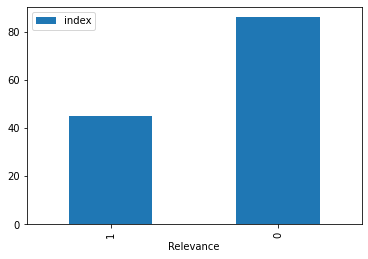

In [ ]:
df_train["Relevance"].reset_index().groupby("Relevance").count().sort_values(by="index").plot(kind="bar") # training set is moderately unbalanced

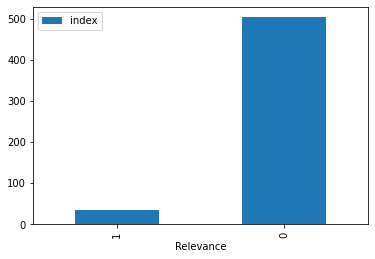

In [ ]:
df_test["Relevance"].reset_index().groupby("Relevance").count().sort_values(by="index").plot(kind="bar") # test set is highly unbalanced

In [ ]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train.dtypes 

Title        object
Abstract     object
Relevance     int64
dtype: object

In [ ]:
df_test.dtypes

Title        object
Abstract     object
Relevance     int64
dtype: object

In [ ]:
df_train.isnull().sum() # nan values

Title        0
Abstract     3
Relevance    0
dtype: int64

In [ ]:
df_test.isnull().sum() # nan values

Title        0
Abstract     6
Relevance    0
dtype: int64

In [ ]:
df_train.shape, df_test.shape

((131, 3), (539, 3))

Removing nan values

In [ ]:
df_train['Abstract'] = df_train['Abstract'].fillna(' ')

In [ ]:
# Merge the Title and Abstract
df_train["Merged"] = df_train["Title"] + df_train["Abstract"]

In [ ]:
df_train.head()

,Title,Abstract,Relevance,Merged
0,The Management of University--Industry Collabo...,In this chapter we will discuss some of the pr...,1,The Management of University--Industry Collabo...
1,Delay and Secrecy: Does Industry Sponsorship J...,The viability of modern open science norms and...,0,Delay and Secrecy: Does Industry Sponsorship J...
2,The role of experimentation in software engine...,Software engineering needs to follow the model...,0,The role of experimentation in software engine...
3,Design Science in Information Systems Research,Two paradigms characterize much of the researc...,0,Design Science in Information Systems Research...
4,Challenges and practices in aligning requireme...,Weak alignment of requirements engineering (RE...,0,Challenges and practices in aligning requireme...


In [ ]:
df_train.isnull().sum()

Title        0
Abstract     0
Relevance    0
Merged       0
dtype: int64

In [ ]:
df_test['Abstract'] = df_test['Abstract'].fillna(' ')
df_test["Merged"] = df_test["Title"] + df_test["Abstract"]

In [ ]:
df_test.head()

,Title,Abstract,Relevance,Merged
0,Applying Options Thinking to Shape Generativit...,Although extant research convincingly argues t...,0,Applying Options Thinking to Shape Generativit...
1,Meeting Industry-Academia Research Collaborati...,Continuous and long-term collaboration between...,1,Meeting Industry-Academia Research Collaborati...
2,Teaching Research Methodologies with a Robot i...,We describe a computer science lab course that...,0,Teaching Research Methodologies with a Robot i...
3,Critical Issues in Requirements Engineering Ed...,Requirements Engineering (RE) is the most cruc...,0,Critical Issues in Requirements Engineering Ed...
4,Selecting the Right Topics for Industry-Academ...,The global software industry and the Software ...,0,Selecting the Right Topics for Industry-Academ...


In [ ]:
df_test.isnull().sum()

Title        0
Abstract     0
Relevance    0
Merged       0
dtype: int64

 Testing bert tokenizer

In [ ]:
# txt = "love song"
# ## bert tokenizer
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# ## bert model
# nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# input_ids = tokenizer(txt, return_tensors="tf")
# input_ids['input_ids']

<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[ 101, 2293, 2299,  102]], dtype=int32)>

In [ ]:
# embedding = nlp(input_ids['input_ids'])
# embedding[0][0]

<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.2619469 , -0.23664388, -0.09885425, ..., -0.25338942,
        -0.130903  ,  0.23669066],
       [ 0.800546  , -0.49794582,  0.9975964 , ..., -0.00949971,
        -0.2147929 , -0.31390828],
       [-0.38215992, -0.57508177,  0.43901923, ..., -0.12765715,
        -0.8740944 , -0.4339524 ],
       [ 0.7887295 ,  0.06433029, -0.30826044, ...,  0.13107422,
        -0.66824263, -0.26013824]], dtype=float32)>

Code credits below @[Link](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)

Augmenting the minority class 1 (because of small dataset)

In [ ]:
def augment_sentence(sentence, aug, num_threads):
    """""""""
    Constructs a new sentence via text augmentation.
    
    Input:
        - sentence:     A string of text
        - aug:          An augmentation object defined by the nlpaug library
        - num_threads:  Integer controlling the number of threads to use if
                        augmenting text via CPU
    Output:
        - A string of text that been augmented
    """""""""
    return aug.augment(sentence, num_thread=num_threads)
    


def augment_text(df, aug, num_threads, num_times):
    """""""""
    Takes a pandas DataFrame and augments its text data.
    
    Input:
        - df:            A pandas DataFrame containing the columns:
                                - 'Merged' containing strings of text to augment.
                                - 'Relevance' binary target variable containing 0's and 1's.
        - aug:           Augmentation object defined by the nlpaug library.
        - num_threads:   Integer controlling number of threads to use if augmenting
                         text via CPU
        - num_times:     Integer representing the number of times to augment text.
    Output:
        - df:            Copy of the same pandas DataFrame with augmented data 
                         appended to it and with rows randomly shuffled.
    """""""""
    # Get rows of data to augment
    to_augment = df[df['Relevance']==1]
    to_augmentX = to_augment['Merged']
    to_augmentY = np.ones(len(to_augmentX.index) * num_times, dtype=np.int8)
    
    # Build up dictionary containing augmented data
    aug_dict = {'Merged':[], 'Relevance':to_augmentY}
    for i in tqdm(range(num_times)):
        augX = [augment_sentence(x, aug, num_threads) for x in to_augmentX]
        aug_dict['Merged'].extend(augX)
    
    # Build DataFrame containing augmented data
    aug_df = pd.DataFrame.from_dict(aug_dict)
    
    return df.append(aug_df, ignore_index=True).sample(frac=1, random_state=42)

In [ ]:
# Define nlpaug augmentation object 
aug10p = nlpaw.ContextualWordEmbsAug(model_path='bert-base-uncased', aug_min=1, aug_p=0.1, action="substitute")

# Upsample minority class ('Relevance' == 1) to create a roughly 50-50 class distribution
balanced_df = augment_text(df_train, aug10p, num_threads=8, num_times=2) # takes more than 9 mins

100%|██████████| 2/2 [09:32<00:00, 286.34s/it]


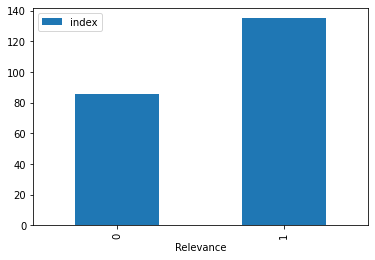

In [ ]:
balanced_df["Relevance"].reset_index().groupby("Relevance").count().sort_values(by="index").plot(kind="bar")

In [ ]:
# save the balanced df
balanced_df.to_csv("Balanced_training.csv", index=False)

In [ ]:
X_train = balanced_df["Merged"]
y_train = balanced_df["Relevance"]

In [ ]:
X_test = df_test["Merged"]
y_test = df_test["Relevance"]

In [ ]:
# changing datatype to str as it is object now and that is not accepted by bert
X_test = df_test["Merged"].astype(str).values.tolist() 

Creating validation set

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [ ]:
# changing datatype to str as it is object now and that is not accepted by bert
X_train = X_train.astype(str).values.tolist() 

In [ ]:
X_valid = X_valid.astype(str).values.tolist() 

Tokenizing df_train["Merged"] using Distilberttokenizer

In [ ]:
from transformers import DistilBertTokenizerFast

#Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
# Define the maximum number of words to tokenize (DistilBERT can tokenize up to 512)
MAX_LENGTH = 256


# Define function to encode text data in batches
def batch_encode(tokenizer, texts, batch_size=32, max_length=MAX_LENGTH):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='longest', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [ ]:
# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)

In [ ]:
# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

In [ ]:
# Encode X_valid
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_valid)

In [ ]:
X_train_ids

<tf.Tensor: shape=(154, 256), dtype=int32, numpy=
array([[  101,  9585,  2869, ...,     0,     0,     0],
       [  101, 10100,  2005, ...,     0,     0,     0],
       [  101,  7861,  8270, ...,     0,     0,     0],
       ...,
       [  101,  9084,  2974, ...,     0,     0,     0],
       [  101,  1031,  1005, ...,     0,     0,     0],
       [  101,  5918,  3330, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
X_train_attention

<tf.Tensor: shape=(154, 256), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
X_test_ids

<tf.Tensor: shape=(539, 256), dtype=int32, numpy=
array([[  101, 11243,  7047, ...,     0,     0,     0],
       [  101,  3116,  3068, ...,     0,     0,     0],
       [  101,  4252,  2470, ...,     0,     0,     0],
       ...,
       [  101,  2875,  5301, ...,     0,     0,     0],
       [  101,  2865,  3436, ...,     0,     0,     0],
       [  101,  3834,  1998, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
X_test_attention

<tf.Tensor: shape=(539, 256), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
X_valid_ids

<tf.Tensor: shape=(67, 256), dtype=int32, numpy=
array([[ 101, 1031, 1005, ...,    0,    0,    0],
       [ 101, 2054, 3084, ...,    0,    0,    0],
       [ 101, 8161, 3231, ..., 1010, 1999,  102],
       ...,
       [ 101, 1996, 6622, ...,    0,    0,    0],
       [ 101, 9283, 1037, ...,    0,    0,    0],
       [ 101, 1031, 1005, ..., 9041, 2006,  102]], dtype=int32)>

Initializing DistilBert Model Architecture

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

DISTILBERT_DROPOUT = 0.2
DISTILBERT_ATT_DROPOUT = 0.2
 
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)
                          
# The bare, pre-trained DistilBERT transformer model outputting raw hidden-states 
# and without any specific head on top.
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Adding Classification layer

In [ ]:
MAX_LENGTH = 256
LAYER_DROPOUT = 0.2
LEARNING_RATE = 5e-5
RANDOM_STATE = 42

def build_model(transformer, max_length=MAX_LENGTH):
    """""""""
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.
    
    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens 
                      in a given sequence.
    
    Output:
      - model:        a compiled tf.keras.Model with added classification layers 
                      on top of the base pre-trained model architecture.
    """""""""
    
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # We only care about DistilBERT's output for the [CLS] token, 
    # which is located at index 0 of every encoded sequence.  
    # Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]
    
    ##                                                 ##
    ## Define additional dropout and dense layers here ##
    ##                                                 ##
    
    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(cls_token)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
model = build_model(distilBERT)

Training

In [ ]:
EPOCHS = 6
BATCH_SIZE = 32
NUM_STEPS = len(X_train) // BATCH_SIZE

# Train the model
train_history1 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
    verbose=1
)

Epoch 1/6
4/4 [==============================] - 9s 944ms/step - loss: 0.6837 - accuracy: 0.5625 - val_loss: 0.6652 - val_accuracy: 0.6418
Epoch 2/6
4/4 [==============================] - 2s 473ms/step - loss: 0.6828 - accuracy: 0.5984 - val_loss: 0.6652 - val_accuracy: 0.6418
Epoch 3/6
4/4 [==============================] - 2s 454ms/step - loss: 0.6696 - accuracy: 0.5902 - val_loss: 0.6652 - val_accuracy: 0.6418
Epoch 4/6
4/4 [==============================] - 2s 458ms/step - loss: 0.6828 - accuracy: 0.5656 - val_loss: 0.6654 - val_accuracy: 0.6418
Epoch 5/6
4/4 [==============================] - 2s 456ms/step - loss: 0.6605 - accuracy: 0.6230 - val_loss: 0.6655 - val_accuracy: 0.6418
Epoch 6/6
4/4 [==============================] - 2s 474ms/step - loss: 0.6642 - accuracy: 0.6016 - val_loss: 0.6654 - val_accuracy: 0.6418


In [ ]:
FT_EPOCHS = 6
BATCH_SIZE = 8
NUM_STEPS = len(X_train) // BATCH_SIZE

# Unfreeze distilBERT layers and make available for training
for layer in distilBERT.layers:
    layer.trainable = True
    
# Recompile model after unfreezing
model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
train_history2 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = FT_EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
    verbose=1
)

Epoch 1/6
19/19 [==============================] - 14s 326ms/step - loss: 0.5273 - accuracy: 0.7105 - val_loss: 1.5546 - val_accuracy: 0.3582
Epoch 2/6
19/19 [==============================] - 5s 247ms/step - loss: 0.4308 - accuracy: 0.7945 - val_loss: 1.6868 - val_accuracy: 0.3433
Epoch 3/6
19/19 [==============================] - 5s 240ms/step - loss: 0.3248 - accuracy: 0.8493 - val_loss: 1.8458 - val_accuracy: 0.3582
Epoch 4/6
19/19 [==============================] - 5s 245ms/step - loss: 0.3002 - accuracy: 0.8630 - val_loss: 1.9050 - val_accuracy: 0.4627
Epoch 5/6
19/19 [==============================] - 5s 242ms/step - loss: 0.2142 - accuracy: 0.9110 - val_loss: 2.3641 - val_accuracy: 0.3881
Epoch 6/6
19/19 [==============================] - 5s 243ms/step - loss: 0.2052 - accuracy: 0.9247 - val_loss: 2.8475 - val_accuracy: 0.3134


Text(0, 0.5, 'Accuracy')

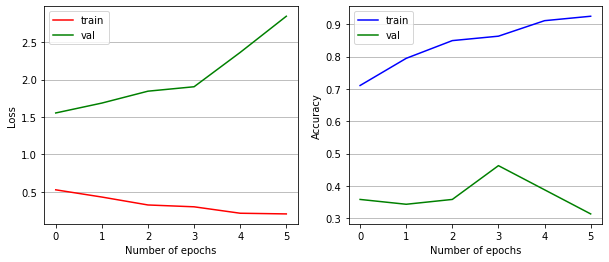

In [ ]:
plt.figure(figsize=(10,4))

ax = plt.subplot(121)
ax.plot(train_history2.history['loss'], 'r', label='train')
ax.plot(train_history2.history['val_loss'], 'g', label='val')
plt.legend()
plt.grid(axis='y')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

ax2 = plt.subplot(122)
ax2.plot(train_history2.history['accuracy'], 'b', label="train")
ax2.plot(train_history2.history['val_accuracy'], 'g', label="val")
plt.grid(axis='y')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")

Evaluation

In [ ]:
score = model.evaluate([X_test_ids, X_test_attention], y_test.to_numpy(), verbose=0)
score[1]

0.573283851146698

In [ ]:
y_pred = model.predict([X_test_ids, X_test_attention])

In [ ]:
def correct_ypred(predicted_vals):
    y_pred = []
    for i in range(len(predicted_vals)):
        small_list = []
        for j in range(len(predicted_vals[i])): 
            if predicted_vals[i][j] > 0.5: 
                small_list.append(1)
            else:
                small_list.append(0)
        y_pred.append(small_list)
    return y_pred

In [ ]:
y_pred = correct_ypred(y_pred)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.60      0.72       503
           1       0.03      0.17      0.05        36

    accuracy                           0.57       539
   macro avg       0.47      0.38      0.39       539
weighted avg       0.85      0.57      0.68       539



In [ ]:
print(confusion_matrix(y_test, y_pred)) # i row=true label, j col=predicted label

[[303 200]
 [ 30   6]]
